# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

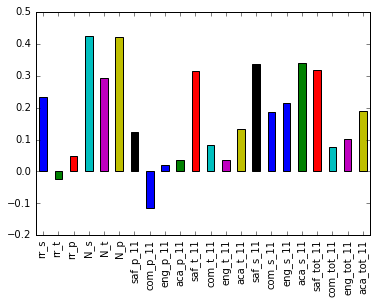

In [11]:
%matplotlib inline
survey_fields
combined.corr()["sat_score"][survey_fields].plot.bar()

the correlation plot between the sat scores and the survey fields, majority have a positive R value. A few fields that catch the eye are N_s, N_p and N_t. 
Number of student/teacher/ parents have a high correlation. 

saf_t11/safs_10 also have a positive correlation, meaning the Safety and respect score from both the students and teachers have a positive correlation to the sat scores. Safety of the teachers and students are directly proportional thus meaning the sat scores tends to be high for the students and teachers who tend to feel safer. This is a fair conclusion to make.

Lastly aca[Academics expectations]- the parents and teacher have low expectation, but the students have high academic expectations. How 3 different types of people view their sat score is evident

# Safety correlation with SAT score

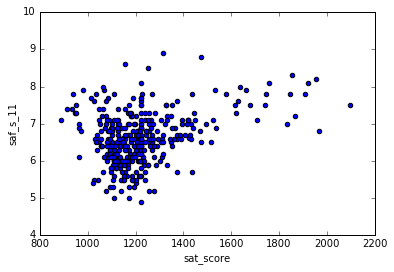

In [12]:
combined.plot.scatter(x = "sat_score", y = "saf_s_11")

The plot between the sat score and student safety score.
The avergage safety score lies in between the 6-7 range. The relation isn't that strong. 

In [13]:
boro = combined.groupby("boro").agg(numpy.mean)
boro["saf_s_11"].sort_values(ascending = False)


boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64

It is evident that of all the boroughs, students rate Manhattan as the safest borough and Brooklyn the least safe 

# Race correlation with SAT scores

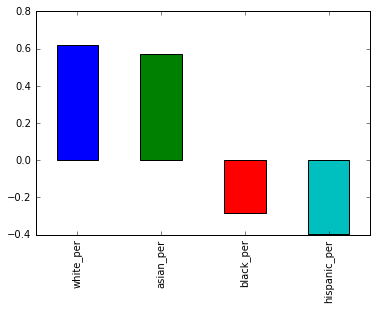

In [14]:
race_fields = ["white_per","asian_per","black_per","hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

White and Asian students have a postive relationship with the SAT score, meaning they are directly proportional. White and Asian students have a higher SAT score in comparisson with other races. 

Black and Hispanic students have a negatuve relationship with the SAT score, meaning these students perform poorly in the test, it is indirectly proportional. This may be due to poor funding and lack of resources.

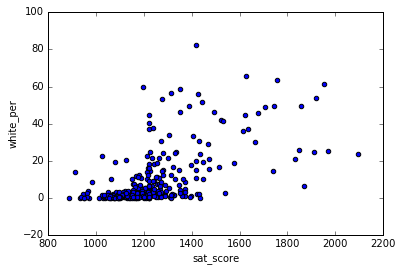

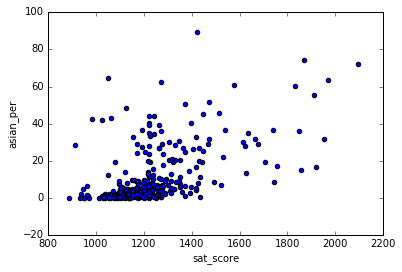

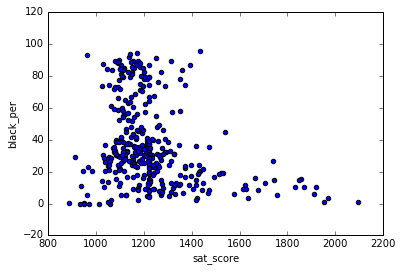

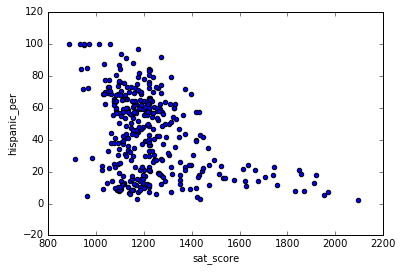

In [15]:
for c in race_fields:
    combined.plot.scatter("sat_score",c)

In [16]:
combined[combined["hispanic_per"] >= 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [33]:
a = combined[combined["hispanic_per"] < 10]
a[a["sat_score"]> 1800]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

# Gender correlation with SAT scores

In [18]:
combined.corr()["sat_score"][["male_per","female_per"]]

# female_school = combined[combined["female_per"]> combined["male_per"]]

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

Not really any relationship between the sat score and gender. There is a minor difference, female students have a slight positive value in comparison to their female counterparts, thus leading to the conclusion that females tend to do a little better. 

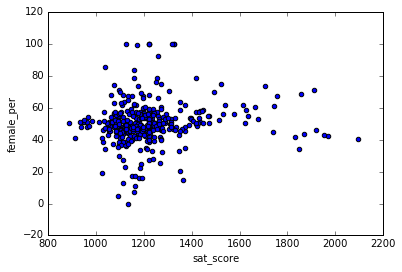

In [19]:
combined.plot.scatter(x = "sat_score", y = "female_per")

In [32]:
female_per = combined[combined["female_per"] > 60]
female_per[female_per["sat_score"]> 1700]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These 5 schools have good acadamic standards.

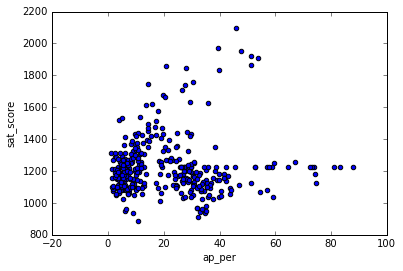

In [39]:
combined["ap_per"] = (combined["AP Test Takers "]/combined["total_enrollment"])*100
combined.plot.scatter("ap_per","sat_score")

In [41]:
combined.corr()["ap_per"]["sat_score"]

0.057170813907669614

Plot between the percentage of the AP exam takers and the sat score.
the correlation isn't strong and evident openly 

In [38]:
combined[["AVERAGE CLASS SIZE","sat_score"]]
combined.corr()["sat_score"]["AVERAGE CLASS SIZE"]

0.3810143308095523

Large class size tend to yeild better results in the SAT exam, as there is a positive correlation between both the average class size and sat score & total_enrollment and sat score

# Conclusions 

1. Manhattan is considered the safest by students and Brooklyn is considered theleast safe of all the boroughs in NY. The SAT scores are directly proportional to the safety score of the boroughs. So students whose schools are in the safer boroughs tend to have a better SAT score.
2. Asians and White students have performed better in their SAT exams, but the black and hispanic students are on the other end of the spectrum. This is due to lack of funding in schools with predominantly with black/ hispanic students. The white and asian students tend to score better due to exposure to better resources which they get due to better funding 
3. Male and Female students there isn't a lot to separate them. Female have a minor edge over their male counterparts.
4. Schools that have a higher proportion of AP students do not perform better in SAT exams.
5. Higher the number of students, better the performance of the school